In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
spark.version

'3.1.1'

In [4]:
spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()

'3.2.0'

In [5]:
import configparser
import praw
from confluent_kafka import Producer
import socket
import json

In [6]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "earliest") \
  .option("subscribe", "comments") \
  .load()

In [7]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [8]:
from IPython.display import display, clear_output
import time

In [9]:
clear_output(wait=True)

In [10]:
raw_stream = df \
    .writeStream \
    .format("memory") \
    .queryName("comment_view") \
    .start()

In [11]:
display(spark.sql('SELECT * FROM comment_view').show(20))

+---+-----+-----+---------+------+---------+-------------+
|key|value|topic|partition|offset|timestamp|timestampType|
+---+-----+-----+---------+------+---------+-------------+
+---+-----+-----+---------+------+---------+-------------+



None

In [12]:
time.sleep(1)

In [42]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM comment_view').show(20))
time.sleep(1)

+--------------------+--------------------+--------+---------+------+--------------------+-------------+
|                 key|               value|   topic|partition|offset|           timestamp|timestampType|
+--------------------+--------------------+--------+---------+------+--------------------+-------------+
|[68 31 64 69 34 3...|[7B 22 69 64 22 3...|comments|        0|     0|2021-06-11 06:28:...|            0|
|[68 31 64 69 34 3...|[7B 22 69 64 22 3...|comments|        0|     1|2021-06-11 06:28:...|            0|
|[68 31 64 69 34 6...|[7B 22 69 64 22 3...|comments|        0|     2|2021-06-11 06:28:...|            0|
|[68 31 64 69 34 7...|[7B 22 69 64 22 3...|comments|        0|     3|2021-06-11 06:28:...|            0|
|[68 31 64 69 34 7...|[7B 22 69 64 22 3...|comments|        0|     4|2021-06-11 06:28:...|            0|
|[68 31 64 69 35 3...|[7B 22 69 64 22 3...|comments|        0|     5|2021-06-11 06:28:...|            0|
|[68 31 64 69 35 3...|[7B 22 69 64 22 3...|comments|   

None

In [14]:
raw_stream.stop()

In [15]:
from pyspark.sql.types import StringType

In [45]:
string_stream_df = df \
    .withColumn("key", df["key"].cast(StringType())) \
    .withColumn("value", df["value"].cast(StringType()))

In [46]:
string_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [ ]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_comments_view") \
    .start()

In [48]:
clear_output(wait=True)
display(spark.sql('SELECT value FROM string_comments_view WHERE key IS NOT NULL').show(20, False))
time.sleep(1)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

None

In [20]:
string_stream.stop()

In [21]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, BooleanType, IntegerType, DoubleType, StringType

In [49]:
schema_inventory = StructType([
    StructField("body", StringType(),  True),
    StructField("link_title", StringType(),  True),
    StructField("name", StringType(), True),
    StructField("link_author", StringType(),  True),
    StructField("ups", IntegerType(), True),
    StructField("created", IntegerType(), True),
    StructField("subreddit_id", StringType(),  True),
    StructField("permalink", StringType(),  True),
    StructField("link_url", StringType(),  True)
])

In [50]:
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_inventory))

In [51]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- body: string (nullable = true)
 |    |-- link_title: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- link_author: string (nullable = true)
 |    |-- ups: integer (nullable = true)
 |    |-- created: integer (nullable = true)
 |    |-- subreddit_id: string (nullable = true)
 |    |-- permalink: string (nullable = true)
 |    |-- link_url: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [53]:
json_stream = json_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("extract_comments") \
    .start()

In [54]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM extract_comments').show(20))
time.sleep(1)

+-------+--------------------+--------+---------+------+--------------------+-------------+
|    key|               value|   topic|partition|offset|           timestamp|timestampType|
+-------+--------------------+--------+---------+------+--------------------+-------------+
|h1di451|{That's literally...|comments|        0|     0|2021-06-11 06:28:...|            0|
|h1di49r|{I mean no
One , ...|comments|        0|     1|2021-06-11 06:28:...|            0|
|h1di4ee|{Napoleon has tha...|comments|        0|     2|2021-06-11 06:28:...|            0|
|h1di4pf|{I think "self me...|comments|        0|     3|2021-06-11 06:28:...|            0|
|h1di4qs|{That would certa...|comments|        0|     4|2021-06-11 06:28:...|            0|
|h1di53y|{lmao only on red...|comments|        0|     5|2021-06-11 06:28:...|            0|
|h1di542|{Weren't we talki...|comments|        0|     6|2021-06-11 06:28:...|            0|
|h1di54f|{Tldr?, Australia...|comments|        0|     7|2021-06-11 06:28:...|   

None

In [27]:
json_stream.stop()

In [28]:
comments_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
            "value.body", \
            "value.link_title", \
            "value.name", \
            "value.link_author", \
            "value.ups", \
            "value.created", \
            "value.subreddit_id", \
            "value.permalink", \
            "value.link_url"
           )

In [29]:
comments_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- body: string (nullable = true)
 |-- link_title: string (nullable = true)
 |-- name: string (nullable = true)
 |-- link_author: string (nullable = true)
 |-- ups: integer (nullable = true)
 |-- created: integer (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- link_url: string (nullable = true)



In [ ]:
comments_stream = comments_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("all_comments_view") \
    .start()

In [118]:
comments_stream.explain()

== Physical Plan ==
WriteToDataSourceV2 org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@7a1d88d0
+- Project [cast(key#7 as string) AS event_key#315, topic#9 AS event_topic#316, timestamp#12 AS event_timestamp#317, from_json(StructField(body,StringType,true), cast(value#8 as string), Some(Etc/UTC)).body AS body#318, from_json(StructField(link_title,StringType,true), cast(value#8 as string), Some(Etc/UTC)).link_title AS link_title#319, from_json(StructField(name,StringType,true), cast(value#8 as string), Some(Etc/UTC)).name AS name#320, from_json(StructField(link_author,StringType,true), cast(value#8 as string), Some(Etc/UTC)).link_author AS link_author#321, from_json(StructField(ups,IntegerType,true), cast(value#8 as string), Some(Etc/UTC)).ups AS ups#322, from_json(StructField(created,IntegerType,true), cast(value#8 as string), Some(Etc/UTC)).created AS created#323, from_json(StructField(subreddit_id,StringType,true), cast(value#8 as string), Some(Etc/UTC)).subreddit_i

In [57]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM all_comments_view ORDER BY ups desc').show(20))
time.sleep(1)

+---------+-----------+--------------------+--------------------+--------------------+----------+-------------------+---+-------+------------+--------------------+--------------------+
|event_key|event_topic|     event_timestamp|                body|          link_title|      name|        link_author|ups|created|subreddit_id|           permalink|            link_url|
+---------+-----------+--------------------+--------------------+--------------------+----------+-------------------+---+-------+------------+--------------------+--------------------+
|  h1di451|   comments|2021-06-11 06:28:...|That's literally ...|Australian swimme...|t1_h1di451|       stoolsample2|  1|   null|    t5_2qh13|/r/worldnews/comm...|https://www.yahoo...|
|  h1di49r|   comments|2021-06-11 06:28:...|I mean no
One , a...|Russia officially...|t1_h1di49r|           Andishen|  1|   null|    t5_2qh13|/r/worldnews/comm...|https://www.cbsne...|
|  h1di4ee|   comments|2021-06-11 06:28:...|Napoleon has that...|British ex

None

In [32]:
comments_stream.stop()

# Watermarked stream

In [33]:
window_duration = '60 seconds'
slide_duration = '10 seconds'

In [86]:
windowed_count_df = comments_stream_df \
    .withWatermark("event_timestamp", "1 minutes") \
    .groupBy(comments_stream_df.link_title, F.window(comments_stream_df.event_timestamp, window_duration, slide_duration)) \
    .count()

In [91]:
windowed_count_df = comments_stream_df \
    .withWatermark("event_timestamp", "1 minutes") \
    .groupBy(F.window(comments_stream_df.event_timestamp, window_duration, slide_duration), comments_stream_df.link_title) \
    .count()

In [110]:
count_stream = windowed_count_df \
    .writeStream \
    .format("memory") \
    .outputMode("Complete") \
    .queryName("count_view") \
    .start()

In [102]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM count_view order by count desc').show(20))
time.sleep(1)

+--------------------+--------------------+-----+
|              window|          link_title|count|
+--------------------+--------------------+-----+
|{2021-06-11 06:28...|Australian swimme...|   42|
|{2021-06-11 06:28...|Australian swimme...|   40|
|{2021-06-11 06:28...|Australian swimme...|   40|
|{2021-06-11 06:28...|Australian swimme...|   39|
|{2021-06-11 06:28...|Australian swimme...|   38|
|{2021-06-11 06:28...|Australian swimme...|   37|
|{2021-06-11 06:28...|Pakistan's larges...|   20|
|{2021-06-11 06:28...|Pakistan's larges...|   20|
|{2021-06-11 06:28...|Pakistan's larges...|   19|
|{2021-06-11 06:28...|Pakistan's larges...|   19|
|{2021-06-11 06:28...|Pakistan's larges...|   19|
|{2021-06-11 06:28...|Pakistan's larges...|   17|
|{2021-06-11 06:35...|Australian swimme...|   14|
|{2021-06-11 07:37...|Australian swimme...|   14|
|{2021-06-11 06:44...|Australian swimme...|   13|
|{2021-06-11 06:45...|Australian swimme...|   13|
|{2021-06-11 09:25...|Saudi Arabia intr...|   13|


None

In [103]:
count_stream.stop()

# Sink to Parquet 

In [38]:
comments_parquet = comments_stream_df \
    .writeStream \
    .format("parquet") \
    .option("checkpointLocation", "path/to/checkpoint/dir") \
    .option("path", "path/to/destination/dir") \
    .start()

In [39]:
comments_parquet.stop()

# Wordcloud

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [135]:
comments = spark.table("all_comments_view")

In [142]:
dict = comments.select('body').collect()

(-0.5, 399.5, 199.5, -0.5)

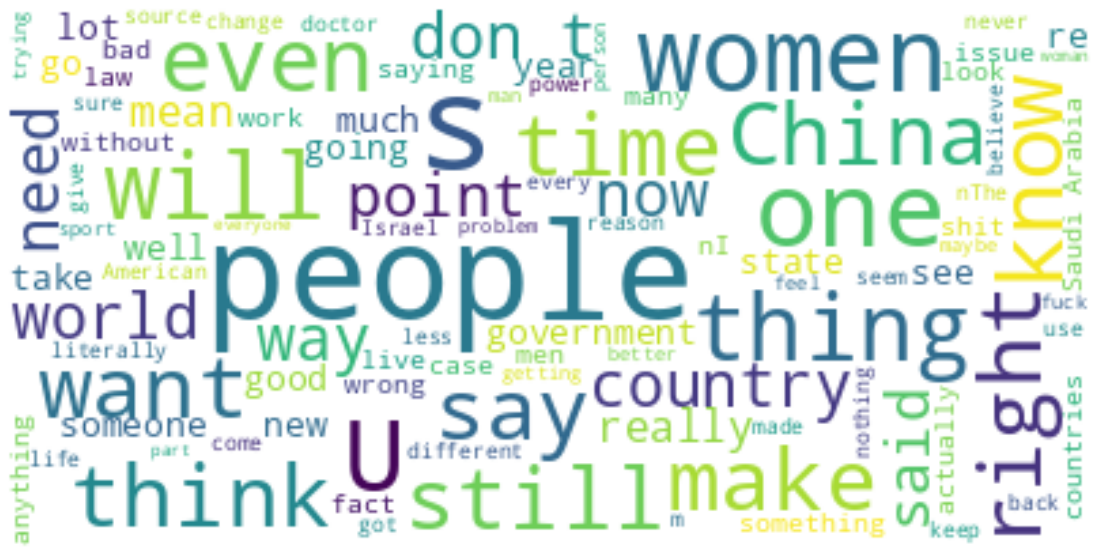

In [153]:
stopwords = set(STOPWORDS)
#update stopwords 
stopwords.update(["Row", "body", "Reddit", "n", "https", "article"])
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(str(dict))
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")